In [9]:
import torch
from torch import nn

import sys
sys.path.append("..")
import pandas as pd

from low_precision_utils import utils
from low_precision_utils import metrics
import numpy as np
import copy
import torch.optim
from torch import nn
import qtorch.quant
import qtorch

In [10]:
DESIRED_STEPS = 50
DATASET_SIZE = 700
BATCH_SIZE = 8
STEPS_PER_EPOCH = DATASET_SIZE // BATCH_SIZE
EPOCHS = DESIRED_STEPS // STEPS_PER_EPOCH + 1 

In [11]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(5, 1)
        self.input_size = (5,)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

    def loss_acc(self, x, y):
        output = self(x)
        loss = nn.BCELoss()(output, y)
        pred = output.round()
        acc = pred.eq(y.view_as(pred)).sum().item() / len(y)
        return {"loss": loss, "acc": acc}

def loadSmallTableData(device):
    train_data = pd.read_csv('../train_data.csv')
    X_train = train_data.drop('purchased', axis=1).values
    y_train = train_data['purchased'].values

    # Load the test data
    test_data = pd.read_csv('../test_data.csv')
    X_test = test_data.drop('purchased', axis=1).values
    y_test = test_data['purchased'].values

    # Convert the data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    return X_train_tensor.to(device), y_train_tensor.to(device), X_test_tensor.to(device), y_test_tensor.to(device)

def getBatches(X, y, batchsize=None):
    length = len(X)
    idx = torch.randperm(length)
    X = X[idx]
    y = y[idx]
    if batchsize is None:
        batchsize = BATCH_SIZE
    for i in range(0, length, BATCH_SIZE):
        yield X[i:i+batchsize], y[i:i+batchsize]


In [12]:
def get_grad(model):
    return model.linear.network.weight.grad
full_precision_format = qtorch.FloatingPoint(8, 23)

def diff_of_grad(wrapper, activation_format, batch_size):
    # at the same traning step
    # that is have the same training data and target
    # we compute the gradient on full precison model
    # then compute the same thing on low precision model (with different seed)
    # we check if for each parameter the estimation is biased

    # this time, we check the difference between activation quantise only
    # and full precision model
    model_weight = wrapper.model_weight
    utils.apply_number_format(model_weight, full_precision_format, 
            full_precision_format, "stochastic", "stochastic")

    X_train, y_train, X_test, y_test = loadSmallTableData(device)
    for X, y in getBatches(X_train, y_train, batch_size):
        break

    model_weight.zero_grad()
    loss = model_weight.loss_acc(X, y)["loss"]
    loss.backward()
    real_grads = np.array(get_grad(model_weight).detach().cpu())
    model_weight.zero_grad()

    utils.apply_number_format(model_weight, activation_format, 
            activation_format, "stochastic", "stochastic")

    grad_estimations = []
    for i in range(50):
        model_weight.zero_grad()
        sample_loss = model_weight.loss_acc(X, y)["loss"]
        sample_loss.backward()
        sample_grad = get_grad(model_weight)
        model_weight.zero_grad()
        grad_estimations.append(sample_grad.detach().cpu())
    grad_estimations = np.array(grad_estimations)
    mean_estimation = np.mean(grad_estimations, axis=0)
    variances = np.mean((grad_estimations - mean_estimation) ** 2, axis=0)
    mse = np.mean((real_grads - grad_estimations) ** 2, axis=0)

    return grad_estimations, mean_estimation, mse, real_grads

In [13]:

device = "cuda"
bit1 = qtorch.FloatingPoint(8, 0)
X_train, y_train, X_test, y_test = loadSmallTableData(device)
model = LogisticRegression().to(device)
model = utils.replace_linear_with_quantized(model)
master_weight = model
model_weight = copy.deepcopy(master_weight)
model_weight = utils.apply_number_format(model_weight, bit1, bit1, "stochastic", "stochastic")
opt = torch.optim.SGD(master_weight.parameters(), lr=0.03, momentum=0)
scheduler = torch.optim.lr_scheduler.ConstantLR(opt)
wrapper = utils.MasterWeightOptimizerWrapper(
    master_weight,
    model_weight,
    opt,
    scheduler,
)
@torch.no_grad()
def test(network, dataset):
    network.eval()
    correct = 0
    total_loss = 0
    i = 0
    n = 0
    with torch.no_grad():
        for data, target in dataset:
            i += 1
            n += len(data)
            loss_acc = network.loss_acc(data, target)
            total_loss += loss_acc["loss"].item()
            correct += loss_acc["acc"] * len(data)
    accuracy = correct / n
    avg_loss = total_loss / i
    network.train()
    return {"test_acc": accuracy, "test_loss": avg_loss}

training_time = 0
import tqdm
import time
test_result_m = {}
result_log = {}
stepi=0
bar = tqdm.tqdm()


man_width = [0, 1, 2, 3, 4, 5, 6, 7, 8]
batch_size = [5,10,20,40,80,160, 320, 640] 
full_precision_format = qtorch.FloatingPoint(8, 23)


grad_real_estimations = []
for epoch in range(EPOCHS):
    start_time = time.perf_counter()
    train_losses, train_accs = [], []
    master_weight.train()
    model_weight.train()

    for X,y in getBatches(X_train,y_train):
        stepi += 1
        result_log.update(wrapper.train_on_batch(X, y))
        bar.update(1)
        bar.set_postfix(result_log)
        result_log["lr"] = opt.param_groups[0]["lr"]
        if stepi >= DESIRED_STEPS:
            test_result_m = test(master_weight, ((X_test, y_test),))
            grad_entire = metrics.grad_on_dataset(master_weight, X_train, y_train)
            result_log.update(grad_entire)
            break
        if stepi % 5 == 0:
            d = {}
            for b in batch_size:
                for m in man_width:
                    format = qtorch.FloatingPoint(8, m)
                    d[(b, m)] = diff_of_grad(wrapper, format, b)
            grad_real_estimations.append(d)

    # wrapper.master_params_to_model_params(quantize=False)
    result_log.update(metrics.grad_on_dataset(master_weight, X_train, y_train))
    training_time += time.perf_counter()-start_time
    test_result_m = test(master_weight, ((X_test, y_test),))
    print(f'epoch % 2d  test loss m %.3f   test acc m %.3f  training time %.2f'%(epoch+1, test_result_m["test_loss"], test_result_m["test_acc"], training_time))
  

50it [01:23,  1.67s/it, loss=0.533, acc=0.875, lr=0.03]


epoch  1  test loss m 0.491   test acc m 0.850  training time 30.92


In [14]:
# grad_estimations, mean_estimation, mse, real_grads

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

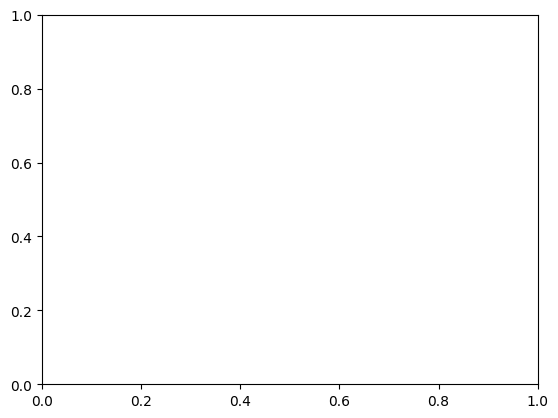

: 

In [16]:
import matplotlib.pyplot as plt
def plot_mse(data, name):
    # contour plot
    table = {
        "batch_size": [],
        "man_width": [],
        "mse": []
    }
    for (b, m), v in data.items():
        table["batch_size"].append(b)
        table["man_width"].append(m)
        mse = v[2]
        # mse = np.log2(mse.mean())
        table["mse"].append(mse)
    df = pd.DataFrame(table)
    pivot_table = df.pivot(index="batch_size",
                    columns="man_width",
                    values="mse")
    X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)
    Z = pivot_table.values
    fig, ax = plt.subplots()
    CS = ax.contourf(X, Y, Z)
    cbar = fig.colorbar(CS)
    ax.set_ylabel("batch_size")
    ax.set_xlabel("man_width")
    ax.set_title("MSE of gradient estimation")
    # ax.set_yscale("log")
    ax.set_yticks(df["batch_size"].unique())
    fig.savefig(f"../out/grad_estimation_var/{name}.png")

for i, grad in enumerate(grad_real_estimations):
    plot_mse(grad, f"grad_estimation_{i}")



In [26]:
import matplotlib.pyplot as plt
def show(mean, real, mse, name):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    mean = mean.flatten()
    real = real.flatten()
    std = np.sqrt(mse.flatten())
    ax.plot(mean, label="mean")
    ax.plot(real, label="real", linestyle="--")
    ax.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.5, label="std")
    ax.set_title(f"Gradient estimation {name}")
    ax.legend()
    fig.savefig(f"../out/prob_grad_estimation/grad_estimation{name}.png")
    plt.close()

In [11]:
for i in range(10):
    for k, v in grad_real_estimations[0].items():
        show(v[1], v[3], v[2], f"{i}_{k[0]}_{k[1]}")
# show(grad_real_estimations[0][(50, 0)][1], grad_real_estimations[0][(50, 0)][3], grad_real_estimations[0][(50, 0)][2])

In [13]:
for mse, var, _ in grad_real_estimations[0].items():
    print(mse, var)

ValueError: not enough values to unpack (expected 3, got 2)

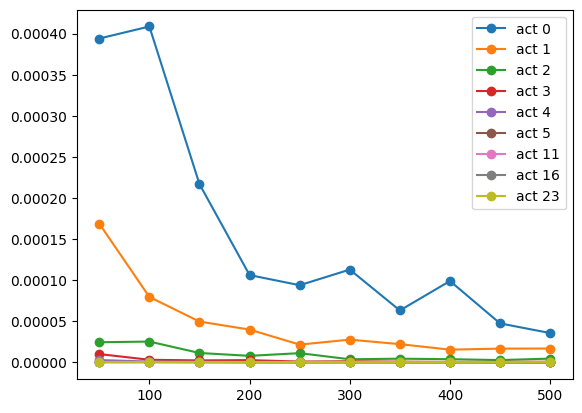

In [15]:
from matplotlib import pyplot as plt
x = grad_real_estimations[0]

for m in man_width[:]:
    line = []
    for i in batch_size[:]:
        line.append(x[(i, m)][0])
    plt.plot(batch_size[:], line, label="act %d"%(m), marker='o')

plt.legend()

[ -4.9164486  -8.71281    -7.0227766  -6.021883  -10.212373  -10.014505
 -11.114283  -12.250494 ]
[(1, 0.03311323), (2, 0.0023833234), (4, 0.0076901275), (8, 0.015389788), (16, 0.0008428872), (32, 0.00096679287), (64, 0.00045109462), (128, 0.00020522671)]


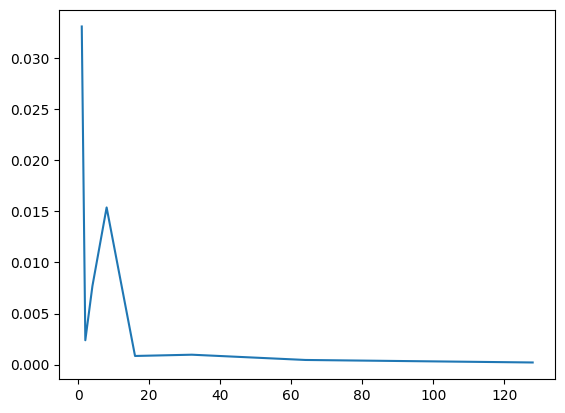

In [16]:
line = []
for i in batch_size:
    line.append(x[(i, 0)][0])
plt.plot(batch_size, line, label="full")
print(np.log2(line))

print(list(zip(batch_size, line)))

[-13.4049835 -11.482871  -14.297741  -15.882759  -13.207628  -11.933285
 -12.426028  -13.178698 ]
[-13.783548 -14.143867 -16.185528 -17.391922 -17.292526 -15.90672
 -16.13744  -16.849789]
[-24.11175  -18.172083 -19.64186  -21.848557 -21.076284 -21.02937
 -21.385838 -21.325912]
[-33.246418 -25.822735 -26.874557 -22.745651 -23.454554 -25.921486
 -24.567205 -24.203922]
[-25.08588  -28.21699  -27.44795  -29.803232 -29.285025 -31.554142
 -29.171656 -30.342936]
[-41.621273 -31.114912 -31.815487 -30.4847   -31.66144  -32.735138
 -33.201267 -33.44305 ]
[-36.553867 -34.645855 -35.341827 -39.175476 -35.57548  -35.921318
 -36.873184 -37.67413 ]
[-42.264343 -40.542313 -39.206047 -40.241253 -40.46177  -40.388573
 -40.496365 -41.529255]
[-49.06448  -44.34336  -43.446312 -43.87265  -44.511036 -43.783546
 -44.932137 -44.4753  ]
[-46.21027  -46.690388 -50.114426 -48.946888 -49.04023  -51.238716
 -47.72947  -50.524914]


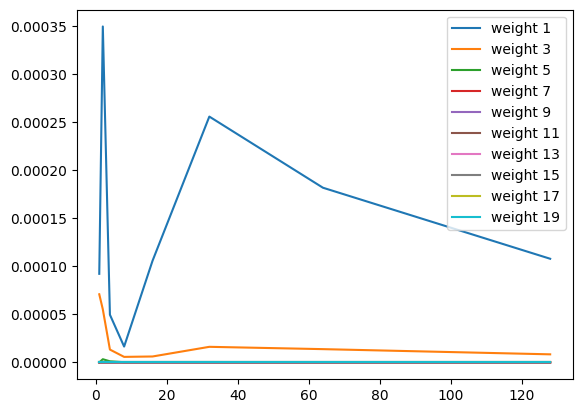

In [19]:
from matplotlib import pyplot as plt
x = grad_real_estimations[0]

for m in man_width:
    line = []
    for i in batch_size:
        line.append(x[(i, 23, m)][0])
    plt.plot(batch_size, line, label="weight %d"%(m))
    print(np.log2(line))


plt.legend()

[-13.115068 -17.166529 -21.26626  -24.633747 -29.448326 -33.026505
 -37.262035 -41.08242  -46.46862  -49.21236 ]


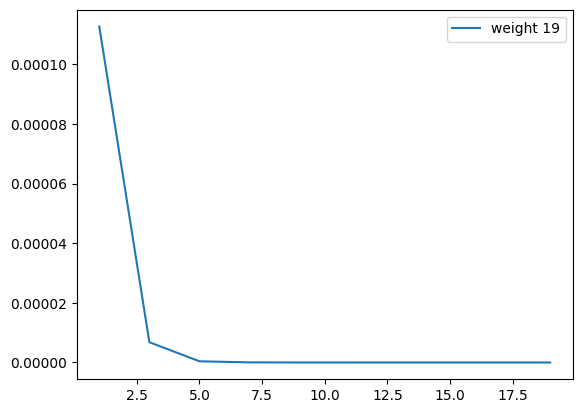

In [34]:
x = grad_real_estimations[0]

line = []
for m in man_width:
    line.append(x[(64,m,23)][0])
plt.plot(man_width, line, label="weight %d"%(m))
print(np.log2(line))
plt.legend()

In [ ]:
import pandas as pd

grad_real_estimations = [pd.DataFrame(i) for i in grad_real_estimations]

In [ ]:
grad_real_estimations[0]

1                                                                \
         1         23        1         2         23        2         3    
         23        1         1         23        2         2         23   
0  0.059134  0.066428  0.107584  0.104060  0.064453  0.074256  0.059208   
1  0.063390  0.084730  0.136624  0.074455  0.069364  0.100888  0.076430   
2  0.024188  0.018350  0.022700  0.018670  0.014485  0.020044  0.022350   
3  0.136556  0.037842  0.095584  0.069185  0.100246  0.074879  0.091510   
4  0.112588  0.050378  0.150031  0.115761  0.070994  0.074960  0.062833   

                                 ...       128                                \
         23        3         4   ...        4         5         23        5    
         3         3         23  ...        4         23        5         5    
0  0.085659  0.072759  0.107001  ...  0.000842  0.001479  0.001470  0.000676   
1  0.111042  0.109822  0.137767  ...  0.000886  0.003798  0.000502  0.000589   
2  0.017001  0.025022  0.026001  ...  0.000220  0.000270  0.000306  0.000177   
3  0.126443  0.094016  0.119107  ...  0.000859  0.001622  0.001613  0.000808   
4  0.086784  0.069619  0.056235  ...  0.001082  0.001501  0.001820  0.001199   

                                                               
         6         23        6         7         23        7   
         23        6         6         23        7         7   
0  0.000481  0.000729  0.001461  0.001654  0.001223  0.005639  
1  0.003857  0.000693  0.001270  0.000404  0.000610  0.001940  
2  0.000365  0.000257  0.000638  0.000235  0.000323  0.000402  
3  0.001866  0.001475  0.000420  0.000426  0.002100  0.002226  
4  0.002505  0.000616  0.000635  0.000886  0.001035  0.001530  

[5 rows x 168 columns]

0.0010157841668476963 0.0004075301747233272 0.0002916751679091242
0.0017151174 0.00039900895 0.0009659661


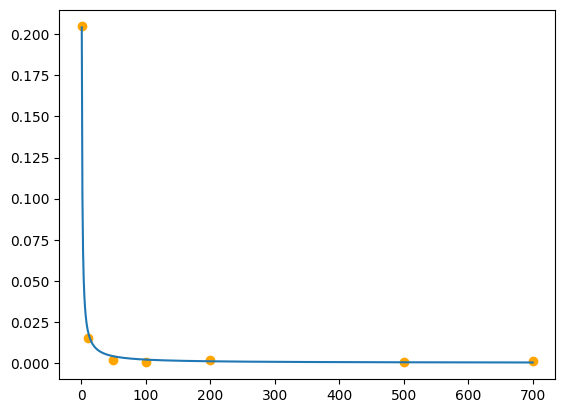

In [ ]:
# make a plot 
import matplotlib.pyplot as plt

# first item of var

n_vars = []
for b, variances in grad_real_estimations[0].items():
    n_vars.append(variances[0, 0])

# fit using y = k / x
# use minimum square to fit
minimum_square = lambda k, x: sum((k / x - n_vars) ** 2)
from scipy.optimize import minimize
res = minimize(minimum_square, 0.1, args=(np.array([1, 10, 50, 100, 200, 500, 700])))
k = res.x[0]
x = np.linspace(1, 700, 700)
y = k / x
plt.plot(x, y, label="fitting curve")

print(y[200], y[500], y[699])
print(n_vars[4], n_vars[5], n_vars[6])


# y from 0 to 0.025

plt.scatter([1, 10, 50, 100, 200, 500, 700], n_vars, label="variance of gradient", marker="o", color="orange")



In [ ]:
def mean_of_vectors(vs):
    sum = np.zeros_like(vs[0])
    for v in vs:
        sum += v
    return sum / len(vs)


def var_of_vectors(vs):
    mean = mean_of_vectors(vs)
    sum = np.zeros_like(vs[0])
    for v in vs:
        sum += (v - mean) ** 2
    return sum / len(vs)

In [ ]:
def show_stats(stats, i):
    print(mean_of_vectors(stats[i][1]))
    print(var_of_vectors(stats[i][1]))
    print(stats[i][0])



In [ ]:
show_stats(grad_real_estimations, 2)

[[-0.06915283  0.02345215 -0.16585937  0.09882812 -0.17070313]]
[[0.00011669 0.00095896 0.00019269 0.00174728 0.00058624]]
[[-0.07003069  0.01795811 -0.16687551  0.08843183 -0.1695634 ]]


In [ ]:
import numpy as np
import scipy.stats as stats

# True vector
def t_test(true_vector, estimated_vectors):
    estimated_vectors = np.array(estimated_vectors)
    print(estimated_vectors.shape)
    # Calculate the average estimated vector
    average_estimated_vector = np.mean(estimated_vectors, axis=0)

    # Calculate the differences
    differences = estimated_vectors - true_vector

    # Perform Paired t-test
    t_statistics, p_values = [], []
    for i in range(true_vector.shape[0]):
        t_statistic, p_value = stats.ttest_1samp(differences[:, i], 0)
        t_statistics.append(t_statistic)
        p_values.append(p_value)

    # Print results
    print(f"True Vector: {true_vector}")
    print(f"Average Estimated Vector: {average_estimated_vector}")
    print(f"Paired t-test p-values: {p_values}")
    significant_differences = np.sum(np.array(p_values) < 0.05)
    print(f"Number of components with significant differences: {significant_differences} out of {true_vector.shape[0]}")

    # Additional Metrics
    # Calculate MSE, RMSE, and Correlation Coefficient for each estimation
    mses = np.mean(differences ** 2, axis=1)
    rmses = np.sqrt(mses)
    correlation_coefficients = [np.corrcoef(true_vector, estimated_vector)[0, 1] for estimated_vector in estimated_vectors]

    # Calculate average MSE, RMSE, and Correlation Coefficient
    average_mse = np.mean(mses)
    average_rmse = np.mean(rmses)
    average_correlation_coefficient = np.mean(correlation_coefficients)

    print(f"Average MSE: {average_mse}")
    print(f"Average RMSE: {average_rmse}")
    print(f"Average Correlation Coefficient: {average_correlation_coefficient}")

In [ ]:
def sample_mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2, n - 1)
    return m, m - h, m + h

def var_of_sample_mean(data, n, true_mean):
    sample_means = []
    for i in range(0, len(data), n):
        sample = data[i:i+n]
        sample_mean = np.mean(sample, axis=0)
        sample_means.append(sample_mean)
    return np.mean((np.array(sample_means) - true_mean) ** 2, axis=0)


In [ ]:
var_of_sample_mean(grad_real_estimations[0][1], 10, grad_real_estimations[0][0])

array([[2.7904744e-05, 7.3696079e-05, 7.3954689e-05, 3.0075224e-05,
        1.1987826e-04]], dtype=float32)

In [ ]:
def perform_big_t_test(true_vectors, estimated_vectors_list):
    """
    Perform a combined t-test on multiple true vectors and their estimated vectors.
    
    Parameters:
    true_vectors (list of np.array): List of true vectors.
    estimated_vectors_list (list of list of np.array): List of lists of estimated vectors.
    
    Returns:
    dict: A dictionary containing the t-statistic and p-value of the combined t-test.
    """
    all_differences = []

    for true_vector, estimated_vectors in zip(true_vectors, estimated_vectors_list):
        estimated_vectors = np.array(estimated_vectors)
        differences = estimated_vectors - true_vector
        all_differences.extend(differences)

    all_differences = np.array(all_differences)
    combined_differences = np.mean(all_differences, axis=0)
    
    combined_differences = combined_differences[0,:]
    print(combined_differences)
    t_statistic, p_value = stats.ttest_1samp(combined_differences, 0)

    return {
        't_statistic': t_statistic,
        'p_value': p_value
    }

def t_test(true_vector, estimated_vectors):
    """
    Perform t-test and calculate metrics to evaluate the estimation quality.
    
    Parameters:
    true_vector (np.array): The true values of the vector.
    estimated_vectors (list): A list of estimated vectors.
    """
    estimated_vectors = np.array(estimated_vectors)
    
    metrics = calculate_metrics(true_vector, estimated_vectors)
    print_metrics(true_vector, metrics)

def my_var(vs, mean):
    sum = np.zeros_like(vs[0])
    for v in vs:
        sum += (v - mean) ** 2
    return sum / len(vs)

def calculate_metrics(true_vector, estimated_vectors):
    """
    Calculate various metrics to evaluate the estimation quality.
    
    Parameters:
    true_vector (np.array): The true values of the vector.
    estimated_vectors (np.array): The estimated vectors.

    Returns:
    dict: A dictionary containing average estimated vector, MSE, RMSE, and correlation coefficients.
    """
    # Calculate the average estimated vector
    average_estimated_vector = np.mean(estimated_vectors, axis=0)
    
    # Calculate the differences
    differences = estimated_vectors - true_vector
    
    # Perform Paired t-test
    t_statistics, p_values = [], []
    for i in range(true_vector.shape[0]):
        t_statistic, p_value = stats.ttest_1samp(differences[:, i], 0)
        t_statistics.append(t_statistic)
        p_values.append(p_value)
    
    # Calculate MSE, RMSE, and Correlation Coefficient for each estimation
    mses = np.mean(differences ** 2, axis=1)
    rmses = np.sqrt(mses)
    correlation_coefficients = [np.corrcoef(true_vector, estimated_vector)[0, 1] for estimated_vector in estimated_vectors]
    n = len(estimated_vectors)
    print(estimated_vectors.shape)
    vars = []
    
    for i in [5, 10, 50, 100, 200, 500, 1000]:
        vars.append(my_var(estimated_vectors[:i], true_vector))
    
    # Calculate average MSE, RMSE, and Correlation Coefficient
    average_mse = np.mean(mses)
    average_rmse = np.mean(rmses)
    average_correlation_coefficient = np.mean(correlation_coefficients)
    
    return {
        'average_estimated_vector': average_estimated_vector,
        'p_values': p_values,
        'significant_differences': np.sum(np.array(p_values) < 0.05),
        'average_mse': average_mse,
        'average_rmse': average_rmse,
        'average_correlation_coefficient': average_correlation_coefficient,
        'vars': vars,
        'mean_difference': np.mean(differences),
        'direction': 'overestimate' if np.mean(differences) > 0 else 'underestimate' if np.mean(differences) < 0 else 'no bias'
    }

def print_metrics(true_vector, metrics):
    """
    Print the calculated metrics.
    
    Parameters:
    true_vector (np.array): The true values of the vector.
    metrics (dict): A dictionary containing the calculated metrics.
    """
    print(f"True Vector: {true_vector}")
    print(f"Average Estimated Vector: {metrics['average_estimated_vector']}")
    print(f"Paired t-test p-values: {metrics['p_values']}")
    print(f"Number of components with significant differences: {metrics['significant_differences']} out of {true_vector.shape[0]}")
    print(f"Average MSE: {metrics['average_mse']}")
    print(f"Average RMSE: {metrics['average_rmse']}")
    print(f"Average Correlation Coefficient: {metrics['average_correlation_coefficient']}")
    print(f"Mean Difference: {metrics['mean_difference']}")
    print(f"Overall Bias Direction: {metrics['direction']}")
    print(f"vars {metrics['vars']}")


for true_vector, estimated_vectors in grad_real_estimations:
    t_test(true_vector, estimated_vectors)
    print("*"*20)

# Perform a combined t-test across all vectors
true_vectors = [true_vector for true_vector, _ in grad_real_estimations]
estimated_vectors_list = [estimated_vectors for _, estimated_vectors in grad_real_estimations]

big_t_test_result = perform_big_t_test(true_vectors, estimated_vectors_list)
print(f"\nCombined t-test result: t-statistic = {big_t_test_result['t_statistic']}, p-value = {big_t_test_result['p_value']}")

(1000, 1, 5)
True Vector: [[ 0.2227383  -0.08161258 -0.34630364 -0.35664153  0.09841983]]
Average Estimated Vector: [[ 0.22679296 -0.08079688 -0.3520156  -0.36356935  0.10035254]]
Paired t-test p-values: [array([6.45162084e-06, 4.57693407e-01, 1.06605290e-08, 2.61258477e-07,
       9.20214423e-03])]
Number of components with significant differences: 4 out of 1
Average MSE: 0.0010830230312421918
Average RMSE: 0.025958824902772903
Average Correlation Coefficient: 0.9959952757369384
Mean Difference: -0.0011673403205350041
Overall Bias Direction: underestimate
vars [array([[8.4854860e-04, 9.7739510e-04, 2.3798102e-04, 1.3081337e-03,
        9.5686722e-05]], dtype=float32), array([[0.00069309, 0.00100617, 0.00069339, 0.00088654, 0.0004211 ]],
      dtype=float32), array([[0.0007868 , 0.00098345, 0.00115028, 0.00200452, 0.00050941]],
      dtype=float32), array([[0.00076847, 0.00094949, 0.00089111, 0.00159497, 0.00050314]],
      dtype=float32), array([[0.00087247, 0.00106122, 0.00100631, 0.

In [ ]:
np.var?

Signature:      
np.var(
    a,
    axis=None,
    dtype=None,
    out=None,
    ddof=0,
    keepdims=<no value>,
    *,
    where=<no value>,
)
Call signature:  np.var(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function var at 0x7f813c146430>
File:            ~/convergence_srsgd/.venv/lib64/python3.9/site-packages/numpy/core/fromnumeric.py
Docstring:      
Compute the variance along the specified axis.

Returns the variance of the array elements, a measure of the spread of a
distribution.  The variance is computed for the flattened array by
default, otherwise over the specified axis.

Parameters
----------
a : array_like
    Array containing numbers whose variance is desired.  If `a` is not an
    array, a conversion is attempted.
axis : None or int or tuple of ints, optional
    Axis or axes along which the variance is computed.  The default is to
    compute the variance of the flattened array.

    .. versionadded:: 1.7.0

    If this is a tuple of

In [ ]:
stats.ttest_1samp?

Signature:
stats.ttest_1samp(
    a,
    popmean,
    axis=0,
    nan_policy='propagate',
    alternative='two-sided',
    *,
    keepdims=False,
)
Docstring:
Calculate the T-test for the mean of ONE group of scores.

This is a test for the null hypothesis that the expected value
(mean) of a sample of independent observations `a` is equal to the given
population mean, `popmean`.

Parameters
----------
a : array_like
    Sample observations.
popmean : float or array_like
    Expected value in null hypothesis. If array_like, then its length along
    `axis` must equal 1, and it must otherwise be broadcastable with `a`.
axis : int or None, default: 0
    If an int, the axis of the input along which to compute the statistic.
    The statistic of each axis-slice (e.g. row) of the input will appear in a
    corresponding element of the output.
    If ``None``, the input will be raveled before computing the statistic.
nan_policy : {'propagate', 'omit', 'raise'}
    Defines how to handle input

In [ ]:
for i in range(len(grad_real_estimations)):
    t_test(grad_real_estimations[i][0], grad_real_estimations[i][1])
    print("*"*10)

(100, 1, 5)
True Vector: [[ 0.32465073  0.1262475  -0.2092338  -0.19066718  0.06783204]]
Average Estimated Vector: [[ 0.32726562  0.12816407 -0.20972656 -0.1953125   0.07077149]]
Paired t-test p-values: [array([0.33836574, 0.20539645, 0.77088319, 0.16036817, 0.35392142])]
Number of components with significant differences: 0 out of 1
Average MSE: 0.0006663842359557748
Average RMSE: 0.019829940050840378
Average Correlation Coefficient: 0.9961007561448865
**********
(100, 1, 5)
True Vector: [[-0.00974826 -0.06938097 -0.11721987 -0.12058986 -0.00532948]]
Average Estimated Vector: [[-0.00894531 -0.07382812 -0.11748535 -0.1209082  -0.00269531]]
Paired t-test p-values: [array([0.76312473, 0.11252516, 0.85586587, 0.92282292, 0.07047263])]
Number of components with significant differences: 0 out of 1
Average MSE: 0.0005938939866609871
Average RMSE: 0.01872951351106167
Average Correlation Coefficient: 0.944159301396356
**********
(100, 1, 5)
True Vector: [[-0.07003069  0.01795811 -0.16687551  0.